Setup and Data Loading

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE

# Load the dataset
df = pd.read_csv('generated_dataset.csv')

# Display basic information
print("Dataset Head:")
print(df.head())
print("\nDataset Info:")
df.info()

Dataset Head:
   Wellhead Temp. (C)  Wellhead Press (psi)  MMCFD- gas  \
0               53.35               1105.13       12.87   
1               72.25               1026.31        3.42   
2               65.08                722.96        6.23   
3               60.71               1557.23       11.71   
4               46.19               1304.42        8.58   

   BOPD (barrel of oil produced per day)  \
0                                1378.93   
1                                1028.75   
2                                2017.92   
3                                 558.22   
4                                1280.47   

   BWPD (barrel of water produced per day)  BSW - basic solid and water (%)  \
0                                  2812.62                            75.64   
1                                   919.92                            44.21   
2                                  1212.42                            17.55   
3                                  1716.09        

 Defining the Target Variable and Initial Analysis

In [2]:
# Analyze the 'CR-corrosion defect' column
print("Summary statistics for the 'CR-corrosion defect' column:")
print(df['CR-corrosion defect'].describe())

# Define the threshold for leaks using the 90th percentile of the data
threshold = df['CR-corrosion defect'].quantile(0.90)
print(f"\nCalculated threshold for leaks (90th percentile): {threshold:.4f}")

# Create the binary target variable 'Leak_Status'
df['Leak_Status'] = (df['CR-corrosion defect'] > threshold).astype(int)

# Verify the class distribution
print("\nClass distribution of the 'Leak_Status' variable:")
print(df['Leak_Status'].value_counts())
print(f"Percentage of leaks: {(df['Leak_Status'].sum() / len(df)) * 100:.2f}%")

Summary statistics for the 'CR-corrosion defect' column:
count    10292.000000
mean         0.211285
std          0.037283
min          0.000900
25%          0.192100
50%          0.213500
75%          0.232800
max          0.405200
Name: CR-corrosion defect, dtype: float64

Calculated threshold for leaks (90th percentile): 0.2503

Class distribution of the 'Leak_Status' variable:
Leak_Status
0    9263
1    1029
Name: count, dtype: int64
Percentage of leaks: 10.00%


Data Preprocessing and Visualization

Creating feature pair plot...


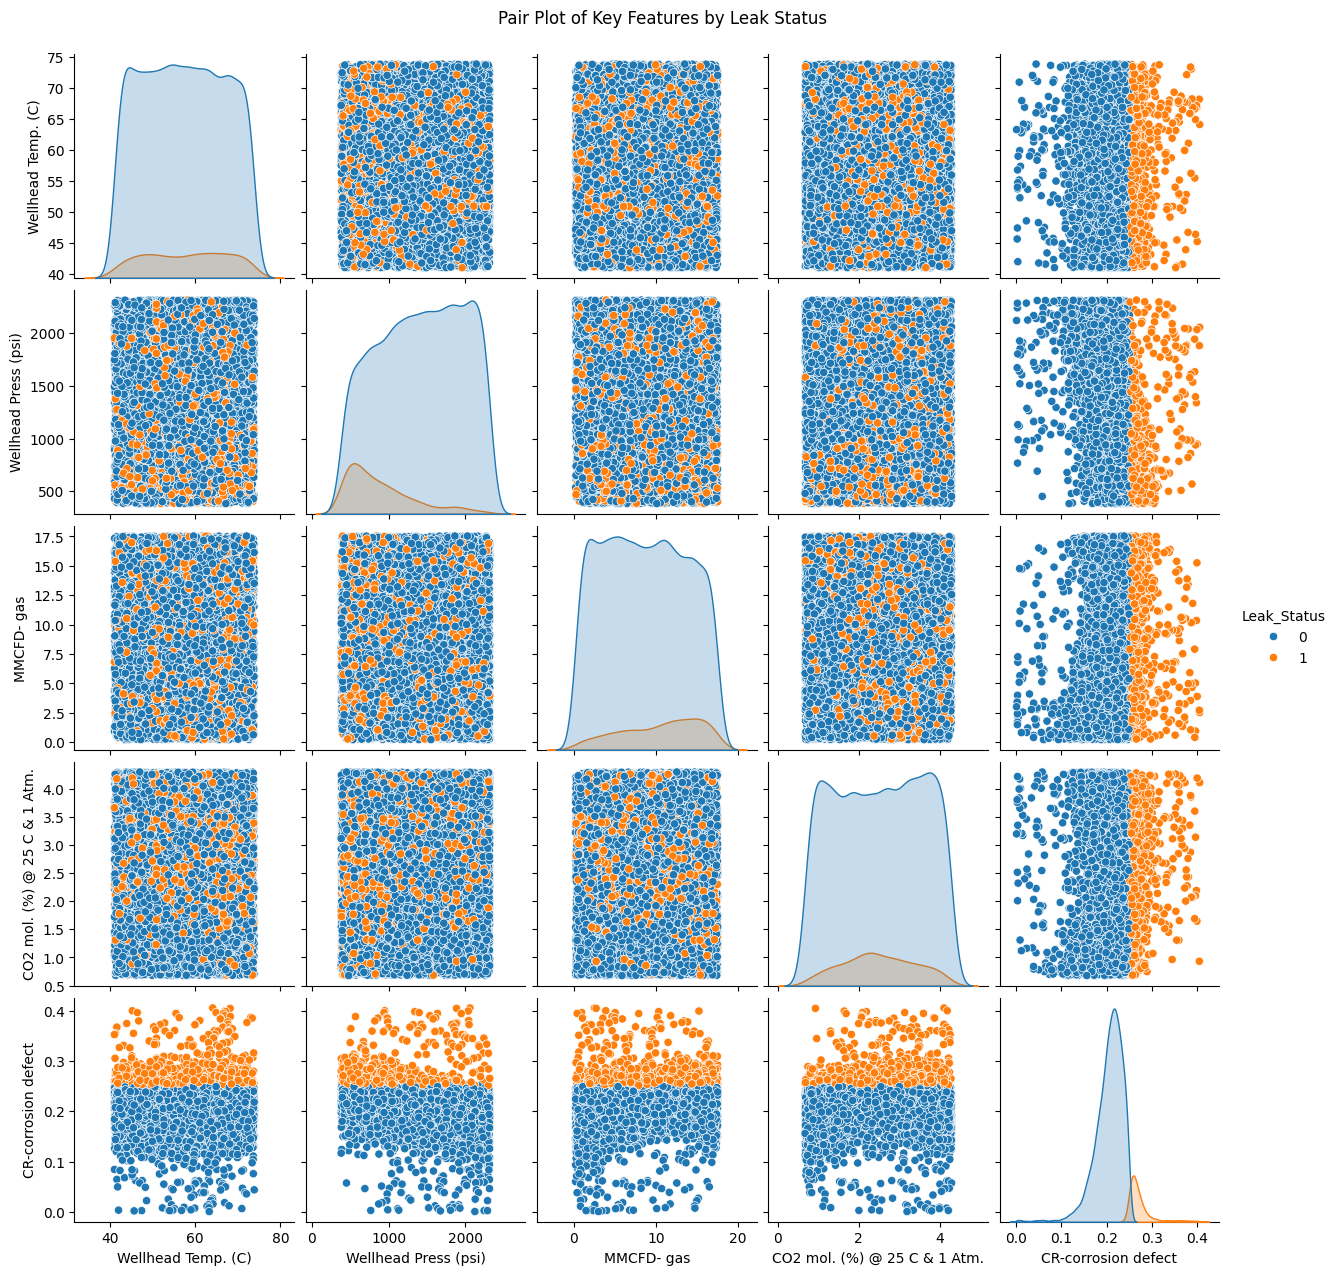

Pair plot displayed. Notice the separation of classes for CR-corrosion defect.


In [3]:
# Drop the original corrosion column and separate features (X) and target (y)
X = df.drop(['CR-corrosion defect', 'Leak_Status'], axis=1)
y = df['Leak_Status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Visualize the distribution of some key features
print("Creating feature pair plot...")
sns.pairplot(df.iloc[:, [0, 1, 2, 6, 8, -1]], hue='Leak_Status')
plt.suptitle('Pair Plot of Key Features by Leak Status', y=1.02)
plt.show()
print("Pair plot displayed. Notice the separation of classes for CR-corrosion defect.")

Model 1 - SVM on Imbalanced Data

In [4]:
# Initialize and train the SVM model on imbalanced data
svm_imbalanced = SVC(random_state=42, probability=True)
svm_imbalanced.fit(X_train_scaled, y_train)
y_pred_imbalanced = svm_imbalanced.predict(X_test_scaled)

# Evaluate the model
print("Evaluation of SVM on Imbalanced Data:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_imbalanced))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_imbalanced))

# Store metrics for later comparison
report_imbalanced = classification_report(y_test, y_pred_imbalanced, output_dict=True)
f1_imbalanced = report_imbalanced['1']['f1-score']
auc_imbalanced = auc(*roc_curve(y_test, svm_imbalanced.predict_proba(X_test_scaled)[:, 1])[:2])

Evaluation of SVM on Imbalanced Data:
Confusion Matrix:
[[2774    5]
 [ 103  206]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2779
           1       0.98      0.67      0.79       309

    accuracy                           0.97      3088
   macro avg       0.97      0.83      0.89      3088
weighted avg       0.97      0.97      0.96      3088



In [8]:
# Model 1.1 - SVM on Imbalanced Data (with Class Weights)

# Initialize and train the SVM model with class_weight'
svm_weighted = SVC(random_state=42, probability=True, class_weight='balanced')
svm_weighted.fit(X_train_scaled, y_train)
y_pred_weighted = svm_weighted.predict(X_test_scaled)

# Evaluate the model
print("Evaluation of SVM with Class Weights:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_weighted))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_weighted))

# Store metrics for later comparison
report_weighted = classification_report(y_test, y_pred_weighted, output_dict=True)
f1_weighted = report_weighted['1']['f1-score']
auc_weighted = auc(*roc_curve(y_test, svm_weighted.predict_proba(X_test_scaled)[:, 1])[:2])

Evaluation of SVM with Class Weights:
Confusion Matrix:
[[2559  220]
 [  43  266]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      2779
           1       0.55      0.86      0.67       309

    accuracy                           0.91      3088
   macro avg       0.77      0.89      0.81      3088
weighted avg       0.94      0.91      0.92      3088



Model 2 - SVM with SMOTE Balancing

In [5]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("\nClass distribution after SMOTE:")
print(y_train_smote.value_counts())

# Train a new SVM model on the balanced data
svm_balanced = SVC(random_state=42, probability=True)
svm_balanced.fit(X_train_smote, y_train_smote)
y_pred_balanced = svm_balanced.predict(X_test_scaled)

# Evaluate the balanced model
print("\nEvaluation of SVM on Balanced Data (SMOTE):")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_balanced))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_balanced))

# Store metrics
report_balanced = classification_report(y_test, y_pred_balanced, output_dict=True)
f1_balanced = report_balanced['1']['f1-score']
auc_balanced = auc(*roc_curve(y_test, svm_balanced.predict_proba(X_test_scaled)[:, 1])[:2])


Class distribution after SMOTE:
Leak_Status
1    6484
0    6484
Name: count, dtype: int64

Evaluation of SVM on Balanced Data (SMOTE):
Confusion Matrix:
[[2626  153]
 [  49  260]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2779
           1       0.63      0.84      0.72       309

    accuracy                           0.93      3088
   macro avg       0.81      0.89      0.84      3088
weighted avg       0.95      0.93      0.94      3088



Model 3 - Hyperparameter Tuning

In [6]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf']
}

# Perform GridSearchCV on the balanced data
grid_search = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

print("\nBest hyperparameters found by GridSearchCV:")
print(grid_search.best_params_)

# Train the final model with the best parameters
svm_tuned = grid_search.best_estimator_
y_pred_tuned = svm_tuned.predict(X_test_scaled)

# Evaluate the tuned model
print("\nEvaluation of Hyperparameter Tuned SVM:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_tuned))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned))

# Store metrics
report_tuned = classification_report(y_test, y_pred_tuned, output_dict=True)
f1_tuned = report_tuned['1']['f1-score']
auc_tuned = auc(*roc_curve(y_test, svm_tuned.predict_proba(X_test_scaled)[:, 1])[:2])


Best hyperparameters found by GridSearchCV:
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}

Evaluation of Hyperparameter Tuned SVM:
Confusion Matrix:
[[2677  102]
 [  71  238]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2779
           1       0.70      0.77      0.73       309

    accuracy                           0.94      3088
   macro avg       0.84      0.87      0.85      3088
weighted avg       0.95      0.94      0.95      3088



Visualizing the Performance Comparison

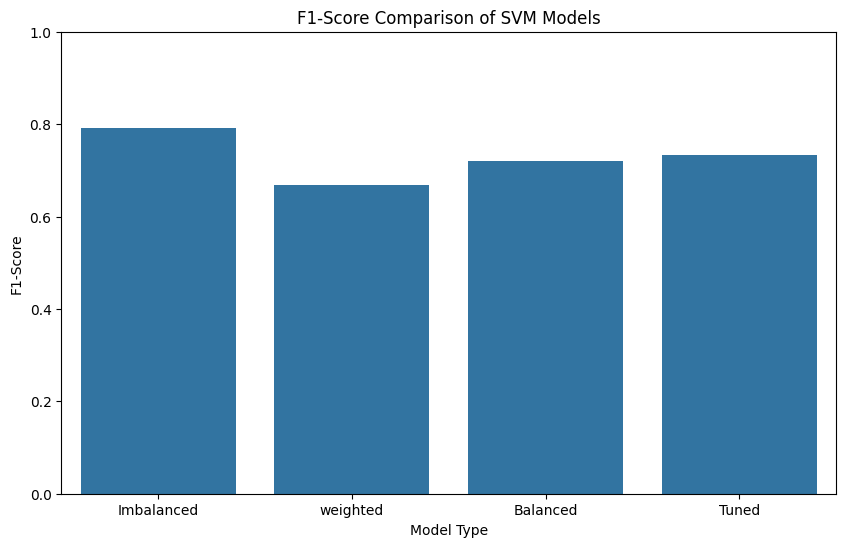

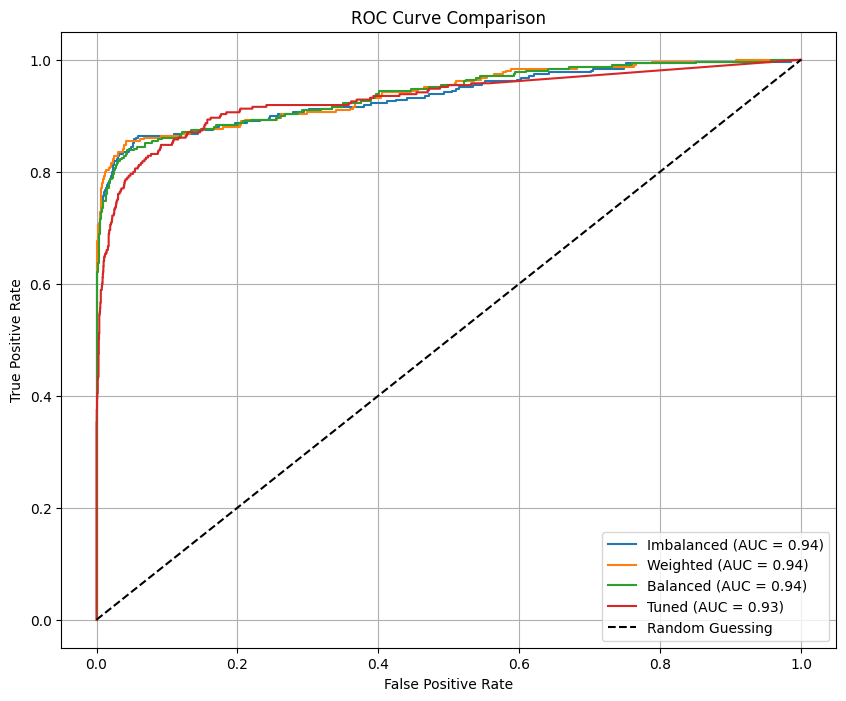

In [10]:
# Prepare data for comparison plot
model_names = ['Imbalanced', 'weighted', 'Balanced', 'Tuned']
f1_scores = [f1_imbalanced, f1_weighted, f1_balanced, f1_tuned]
auc_scores = [auc_imbalanced, auc_weighted, auc_balanced, auc_tuned]

# Create a bar chart for F1-scores
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=f1_scores)
plt.title('F1-Score Comparison of SVM Models')
plt.ylabel('F1-Score')
plt.xlabel('Model Type')
plt.ylim(0, 1.0)
plt.show()

# Create ROC curve comparison plot
fpr_imbalanced, tpr_imbalanced, _ = roc_curve(y_test, svm_imbalanced.predict_proba(X_test_scaled)[:, 1])
fpr_weighted, tpr_weighted, _ = roc_curve(y_test, svm_weighted.predict_proba(X_test_scaled)[:, 1])
fpr_balanced, tpr_balanced, _ = roc_curve(y_test, svm_balanced.predict_proba(X_test_scaled)[:, 1])
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, svm_tuned.predict_proba(X_test_scaled)[:, 1])

plt.figure(figsize=(10, 8))
plt.plot(fpr_imbalanced, tpr_imbalanced, label=f'Imbalanced (AUC = {auc_imbalanced:.2f})')
plt.plot(fpr_weighted, tpr_weighted, label=f'Weighted (AUC = {auc_weighted:.2f})')
plt.plot(fpr_balanced, tpr_balanced, label=f'Balanced (AUC = {auc_balanced:.2f})')
plt.plot(fpr_tuned, tpr_tuned, label=f'Tuned (AUC = {auc_tuned:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()